# OpenVINO Inference with 🤗 Optimum

This notebook is a playground for running inference with OpenVINO on Transformers models with Optimum. The first part of this notebook explains the different ways to load a model, and some options specific to OpenVINO, like doing inference on an Intel GPU. The second part of this notebook consists of small examples for different supported tasks. 

Do not forget to install the required dependencies before running this notebook by uncommenting the cell below to install these requirements in your current Python environment. The audio classification example requires [ffmpeg](https://ffmpeg.org/download.html).

In [1]:
# %pip install optimum[openvino] ipywidgets pillow torchaudio soundfile librosa

## Part 1: Inference with OpenVINO

To load an OpenVINO model, you can just replace the Transformers `AutoModelForXxx` class with the corresponding Optimum `OVModelForXxx` class. This will allow you to load models hosted locally or from the Hugging Face [Hub](https://huggingface.co/models).

The method can be used to load OpenVINO models (stored as openvino_model.xml and openvino_model.bin) and PyTorch models (stored as pytorch_model.bin). To load a PyTorch model and convert it to the OpenVINO format on-the-fly, you can set export=True when loading your model. Don't forget to save the resulting OpenVINO model, using the `.save_pretrained(save_dir)` method. The OpenVINO model will be saved in the `save_dir` directory.

For faster model loading, we recommend to always save the converted model, avoiding to convert the models multiple times.

In [2]:
from optimum.intel import OVModelForQuestionAnswering

# Load PyTorch model from the Hub and export to OpenVINO in the background
model = OVModelForQuestionAnswering.from_pretrained("distilbert-base-uncased-distilled-squad", export=True)

# Save the converted model to a local directory
model.save_pretrained("distilbert-base-uncased-distilled-squad-ov-fp32")

# Load the OpenVINO model directly from the directory
model = OVModelForQuestionAnswering.from_pretrained("distilbert-base-uncased-distilled-squad-ov-fp32")

/home/helena/venvs/openvino_env/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/helena/venvs/openvino_env/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/helena/venvs/openvino_env/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/helena/venvs/openvino_env/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_

To convert input data like text and images to numeric values that the model expects, a preprocessor is used. For text models this is a Tokenizer, for image models an ImageProcessor, for audio models a FeatureExtractor. It is useful to save the preprocessor for a particular model in the same directory as the model, to facilitate the loading.

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-distilled-squad")
tokenizer.save_pretrained("distilbert-base-uncased-distilled-squad-ov-fp32")

('distilbert-base-uncased-distilled-squad-ov-fp32/tokenizer_config.json',
 'distilbert-base-uncased-distilled-squad-ov-fp32/special_tokens_map.json',
 'distilbert-base-uncased-distilled-squad-ov-fp32/vocab.txt',
 'distilbert-base-uncased-distilled-squad-ov-fp32/added_tokens.json',
 'distilbert-base-uncased-distilled-squad-ov-fp32/tokenizer.json')

### Run Inference


#### Running inference with Transformers Pipelines

The easiest way to do inference on Transformers model is by using Transformers [pipelines](https://huggingface.co/docs/transformers/main/en/pipeline_tutorial), which takes care of both the pre-processing and post-processing steps. For example, for a question-answering model, you give it a question and a context, and it returns an answer; for an image classification model, you give it a path to an image and it returns the classification prediction for that image..


In [4]:
# ov_pipe.preprocess??
# ov_pipe.postprocess??

In [5]:
from optimum.intel import OVModelForQuestionAnswering
from transformers import AutoTokenizer, pipeline

model = OVModelForQuestionAnswering.from_pretrained("distilbert-base-uncased-distilled-squad-ov-fp32")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-distilled-squad")
ov_pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
ov_pipe("What is OpenVINO?", "OpenVINO is a framework for deep learning inference optimization")

Compiling the model to CPU ...


{'score': 0.8515874147415161,
 'start': 12,
 'end': 64,
 'answer': 'a framework for deep learning inference optimization'}

#### Running inference by defining the pre-process and post-process steps manually

A second way to do inference is to do inference directly and write pre- and postprocessing code yourself. For many models on the Hugging Face Hub the Model Card gives an example, and Hugging Face [model documentation](https://huggingface.co/docs/transformers/index) is a great starting point too.

The code below is based on the example of the [distilbert-base-cased-distilled-squad](https://huggingface.co/distilbert-base-cased-distilled-squad) model card and returns the same answer as the pipeline method.

In [6]:
import torch
from optimum.intel import OVModelForQuestionAnswering
from transformers import AutoTokenizer, pipeline

model = OVModelForQuestionAnswering.from_pretrained("distilbert-base-uncased-distilled-squad-ov-fp32")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-distilled-squad-ov-fp32")

question, text = "What is OpenVINO?", "OpenVINO is a framework for deep learning inference optimization"

inputs = tokenizer(question, text, return_tensors="pt")
outputs = model(**inputs)

answer_start_index = torch.argmax(outputs.start_logits, axis=-1).item()
answer_end_index = torch.argmax(outputs.end_logits, axis=-1).item()

predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
tokenizer.decode(predict_answer_tokens)

Compiling the model to CPU ...


'a framework for deep learning inference optimization'

### OpenVINO features

- For improved performance, it is sometimes useful to reshape the model to use static input shapes
- On GPU, inference uses FP16 by default (GPUs contain optimizations for computations with FP16 data). On 4th generation and later Intel® Xeon® Scalable Processors, inference uses BF16 by default. 
- OpenVINO supports inference on Intel GPU, either an integrated GPU in your laptop or desktop, or an Intel discrete GPU, for example Intel Arc. 

By default, when loading a model with `model = OVModelForXxx.from_pretrained(model_id)`, it is compiled on CPU. If you need to modify the model, for example to use static shapes, you can set `compile=False` to the `.from_pretrained()` method, to skip the compilation step, as the model will have to be compiled again after steps such as reshaping or changing device. The model can then be compile with `model.compile()`. In the case the model was not compiled, it will be automatically done before the first inference, resulting in an increase of the first inference latency, since it will include the model compilation time.

#### Using Static Shapes

Using static shapes can sometimes be useful to speed up inference. To reshape the model to use static shapes, use the `.reshape()` method. 

When a model is reshaped to static shapes, all inputs need to be of that specific shape: inputs that have a shorter sequence length need to be padded, inputs with a longer sequence length need to be truncated. When doing inference without a pipeline, you can set the tokenizer's parameters such as the `padding`, `max_length` and `truncation` accordingly :

```
inputs = tokenizer(question, text, return_tensors="pt", padding="max_length", max_length=128, truncation=True)
```

To work seemlessly with a pipeline, the pipeline needs to support settings for padding, maximum sequence length and truncation. Not all pipelines support this at the moment, but support for that is planned. Currently, pipelines for question answering, text classification and image classification work well with static shapes.

See Hugging Face's [padding and truncation documentation](https://huggingface.co/docs/transformers/pad_truncation) for more information on the possible values.

In [7]:
from optimum.intel import OVModelForQuestionAnswering
from transformers import AutoTokenizer, pipeline

model = OVModelForQuestionAnswering.from_pretrained(
    "helenai/distilbert-base-uncased-distilled-squad-ov-fp32", compile=False
)
tokenizer = AutoTokenizer.from_pretrained("helenai/distilbert-base-uncased-distilled-squad-ov-fp32")

max_length = 128
model.reshape(batch_size=1, sequence_length=max_length)
model.compile()

ov_pipe = pipeline(
    "question-answering",
    model=model,
    tokenizer=tokenizer,
    max_seq_len=max_length,
    padding="max_length",
    truncation=True,
)
ov_pipe("What is OpenVINO?", "OpenVINO is a toolkit for deep learning inference optimization")

Compiling the model to CPU ...


{'score': 0.7991424798965454,
 'start': 12,
 'end': 62,
 'answer': 'a toolkit for deep learning inference optimization'}

#### Saving Model in FP16 format

`model.half()` converts the model weights to FP16 precision. This reduces the size of the model by half, with usually a negligible impact on accuracy.

In [8]:
model.half()
model.save_pretrained("distilbert-base-uncased-distilled-squad-ov-fp16")

#### Loading Model on GPU

A model can be loaded to GPU by using `model.to("GPU")` or by passing `device` to `from_pretrained()`.

GPU inference will automatically run with FP16 precision, regardless of the precision of the weights of the model. To override this, and force FP32 precision you can pass an `ov_config` argument to `.from_pretrained()`: 

```
model = OVModelForQuestionAnswering.from_pretrained(model_id,
    device_name="GPU",
    ov_config={"INFERENCE_PRECISION_HINT": "f32"}
)
```

OpenVINO's `Core().available_devices` property shows the supported devices on the system. 

In [9]:
from openvino.runtime import Core

for device in Core().available_devices:
    print(device, Core().get_property(device, "FULL_DEVICE_NAME"))

CPU 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz
GPU Intel(R) Iris(R) Xe Graphics (iGPU)


In [10]:
# Use `model.to()` to compile the model on GPU if a GPU is found
if "GPU" in Core().available_devices:
    model.reshape(1, 28)
    model.to("gpu")
    model.compile()
    print(ov_pipe.model._device)

Compiling the model to GPU ...
Setting OpenVINO CACHE_DIR to /home/helena/.cache/huggingface/hub/models--helenai--distilbert-base-uncased-distilled-squad-ov-fp32/snapshots/a9da64102a84c4b3f110c4d627937a110e56257f/model_cache


GPU


In [11]:
# Set the device directly with `.from_pretrained()`
if "GPU" in Core().available_devices:
    model = OVModelForQuestionAnswering.from_pretrained("distilbert-base-uncased-distilled-squad-ov-fp16", device="GPU")

Compiling the model to GPU ...
Setting OpenVINO CACHE_DIR to distilbert-base-uncased-distilled-squad-ov-fp16/model_cache


## Part 2: Task Examples

In this section, we give a short example for all supported `OVModelForXxx` classes. 
We use pre-converted models from the Hugging Face Hub that are stored in FP16 format for faster download times.

Each task is a standalone example that contains all imports and data, so you can easily copy/paste it to a script or new notebook.

### Audio Classification

Audio classification is the task of automatically categorizing audio data into classes or categories. See Hugging Face's [audio-classification](https://huggingface.co/tasks/audio-classificationhttps://huggingface.co/tasks/audio-classification) documentation for more information.

In this example, we use the [MIT/ast-finetuned-speech-commands-v2](https://huggingface.co/MIT/ast-finetuned-speech-commands-v2) model to do inference on an audio file from the [speech commands](https://huggingface.co/datasets/speech_commands/viewer/v0.01/test) dataset. You can try your own audio file too. To do that, set `audio_sample = /path/to/audio_file`. To see the classes that this model was trained on, run `model.config.id2label`

The model pipeline needs ffmpeg. On Ubuntu Linux: `sudo apt install ffmpeg`; see https://ffmpeg.org/download.html for other OSs

In [12]:
from IPython.display import Audio
from optimum.intel import OVModelForAudioClassification
from transformers import AutoFeatureExtractor, pipeline
from datasets import load_dataset

model_id = "helenai/MIT-ast-finetuned-speech-commands-v2-ov"
model = OVModelForAudioClassification.from_pretrained(model_id)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)
ov_pipe = pipeline("audio-classification", model=model, feature_extractor=feature_extractor)

# streaming=true enables loading one item from the dataset without downloading the full dataset
dataset = load_dataset("speech_commands", "v0.02", streaming=True, trust_remote_code=True)
audio_sample = next(iter(dataset["test"]))

Compiling the model to CPU ...


In [13]:
if isinstance(audio_sample, dict):
    audio_data = audio_sample["audio"]["array"]
    sampling_rate = audio_sample["audio"]["sampling_rate"]
else:
    # if audio_sample is not a dataset item, it should be the path to an audio file
    audio_data = audio_sample
    sampling_rate = None

display(Audio(audio_data, rate=sampling_rate))

ov_pipe(audio_data, top_k=3)

[{'score': 0.9999935626983643, 'label': 'backward'},
 {'score': 3.4823816008611175e-07, 'label': 'forward'},
 {'score': 3.3890643180711777e-07, 'label': 'wow'}]

### Text Generation

Text generation models complete text from a given prompt. See [Hugging Face's text-generation](https://huggingface.co/tasks/text-generation) documentation for more information.

In this example, we use the [https://huggingface.co/gpt2](gpt2) model. Please check out the [model card](https://huggingface.co/gpt2) for this model for more information, including limitations and bias.

In [14]:
from optimum.intel import OVModelForCausalLM
from transformers import AutoTokenizer, pipeline

model_id = "helenai/gpt2-ov"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = OVModelForCausalLM.from_pretrained(model_id)
ov_pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
ov_pipe("Hello, I'm a language model,", max_length=30, num_return_sequences=3)

Provided model does not contain state. It may lead to sub-optimal performance.Please reexport model with updated OpenVINO version >= 2023.3.0 calling the `from_pretrained` method with original model and `export=True` parameter
Compiling the model to CPU ...
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, so I'm really interested in programming. I've always been a programming student. But for a long time,"},
 {'generated_text': "Hello, I'm a language model, because I don't think I ever spoke on paper to an editor. I'm simply someone reading a paper."},
 {'generated_text': "Hello, I'm a language model, I understand. Your mother was talking to you. No, well, my grandmother had said that she heard '"}]

### Image Classification

Image classification is the task of automatically categorizing image data into classes or categories. See [Hugging Face's image-classification documentation](https://huggingface.co/tasks/image-classification) for more information.

In this example we use the [microsoft/swin-tiny-patch4-window7-224](https://huggingface.co/microsoft/swin-tiny-patch4-window7-224) model which was pretrained on [ImageNet](https://en.wikipedia.org/wiki/ImageNet) which contains 1000 classes. Please check out the [model card](https://huggingface.co/microsoft/swin-tiny-patch4-window7-224) for more information about this model.

Vision transformer models can have fixed static shapes and result in an error when loading them. We recommend using static shapes and setting `compile=False` on loading the model. The image classification pipeline resizes the images to the size stored in the feature extractor/image processor, so we can reshape the model to that size.

For more great images of Coco the dog, see https://www.flickr.com/photos/cococv/

Compiling the model to CPU ...


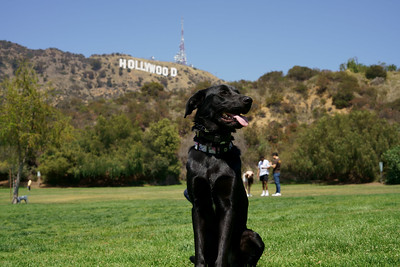

[{'score': 0.4759257435798645, 'label': 'flat-coated retriever'},
 {'score': 0.10909581184387207, 'label': 'Labrador retriever'},
 {'score': 0.0819605216383934, 'label': 'Great Dane'}]

In [15]:
from IPython.display import Image
from optimum.intel import OVModelForImageClassification
from transformers import AutoImageProcessor, pipeline

model_id = "helenai/microsoft-swin-tiny-patch4-window7-224-ov"
model = OVModelForImageClassification.from_pretrained(model_id, compile=False)
image_processor = AutoImageProcessor.from_pretrained(model_id)

model.reshape(1, 3, image_processor.size["height"], image_processor.size["width"])
model.compile()
ov_pipe = pipeline("image-classification", model=model, feature_extractor=image_processor)

image_url_or_path = "https://live.staticflickr.com/65535/51120373723_431ea5d1f5_w_d.jpg"
display(Image(image_url_or_path))
ov_pipe(image_url_or_path, top_k=3)

### Masked Language Modeling / Fill Mask

Masked language modeling is the task of masking some of the words in a sentence and predicting which words should replace those masks. The masked words are replaced with a token, such as \[MASK\]. Doing inference on the model predicts a word to replace the mask token. See [Hugging Face's fill-mask documentation](https://huggingface.co/tasks/fill-mask) for more information.

In this example we use the [bert-base-uncased](https://huggingface.co/bert-base-uncased) model. Please check out the [model card](https://huggingface.co/bert-base-uncased) for this model for more information, including limitations and bias.

In [16]:
from optimum.intel import OVModelForMaskedLM
from transformers import AutoTokenizer, pipeline

model_id = "helenai/bert-base-uncased-ov"
model = OVModelForMaskedLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
ov_pipe = pipeline("fill-mask", model=model, tokenizer=tokenizer)

sentence = f"I am a {tokenizer.mask_token} model"
ov_pipe(sentence, top_k=2)

Compiling the model to CPU ...


[{'score': 0.09604837000370026,
  'token': 4827,
  'token_str': 'fashion',
  'sequence': 'i am a fashion model'},
 {'score': 0.09326566755771637,
  'token': 2535,
  'token_str': 'role',
  'sequence': 'i am a role model'}]

### Question Answering

Question Answering models predict an answer based on a question. Question-answering models based on the BERT architecture, like we use in this example, require a question and a context which contains the answer. See [Hugging Face's question-answering documentation](https://huggingface.co/tasks/question-answering) for more information.

In this example we use the [distilbert-base-uncased-distilled-squad](https://huggingface.co/distilbert-base-uncased-distilled-squad) model. Refer to the [model card](https://huggingface.co/distilbert-base-uncased-distilled-squad) for more information about this model, including risks, limitations and biases.

To use static shapes with question-answering models, add the `max_seq_len` parameter to the `pipeline()` call. For example: 

```python
pipeline("question-answering", model=model, tokenizer=tokenizer, max_seq_len=256, padding="max_length", truncation=True)
```

In [17]:
from optimum.intel import OVModelForQuestionAnswering
from transformers import AutoTokenizer, pipeline

# Load the model and tokenizer saved in Part 1 of this notebook. Or use the line below to load them from the hub
# model_id = "helenai/distilbert-base-uncased-distilled-squad-ov-fp32"
model_id = "distilbert-base-uncased-distilled-squad-ov-fp32"
model = OVModelForQuestionAnswering.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
ov_pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
ov_pipe("What is OpenVINO?", "OpenVINO is an open source toolkit for deep learning inference optimization.")

Compiling the model to CPU ...


{'score': 0.5305243730545044,
 'start': 12,
 'end': 75,
 'answer': 'an open source toolkit for deep learning inference optimization'}

### Sequence-to-sequence (Seq2Seq)

Sequence to Sequence, or encoder-decoder, models can do different tasks, such as translation, summarization and question answering. The [Hugging Face Course](https://huggingface.co/course/chapter1/1) has a great [7 minute video](https://huggingface.co/course/chapter1/7?fw=pt) which explains more about this class of models.

In this example we use the [t5-small](https://huggingface.co/t5-small) model to show translation from English to German and English to French. Refer to the [model card](https://huggingface.co/t5-small) and the [T5 documentation](https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5Model) for more information on this model.

For encoder/decoder models, the `model.generate()` method is a powerful way to do inference. Pipelines are also supported. In this example we show how to use both methods.

In [18]:
from optimum.intel import OVModelForSeq2SeqLM
from transformers import AutoTokenizer, pipeline

model_id = "helenai/t5-small-ov"
model = OVModelForSeq2SeqLM.from_pretrained(model_id, compile=False, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

input_ids = tokenizer("translate English to German: This house is wonderful.", return_tensors="pt").input_ids
outputs = model.generate(input_ids, max_new_tokens=10)
tokenizer.decode(outputs[0], skip_special_tokens=True)

Compiling the encoder to CPU ...
Compiling the decoder to CPU ...
Compiling the decoder to CPU ...


'Das Haus ist wunderbar.'

In [19]:
# Show the pipeline tasks for this model
list(model.config.task_specific_params.keys())

['summarization',
 'translation_en_to_de',
 'translation_en_to_fr',
 'translation_en_to_ro']

In [20]:
ov_pipe = pipeline("translation_en_to_fr", model=model, tokenizer=tokenizer)
ov_pipe("What is a sequence to sequence model?")

[{'translation_text': "Qu'est-ce qu'un modèle de séquence à séquence?"}]

### Text/Sequence Classification

Sequence classification is the task of automatically classifiying text sequences, such as sentences, into classes or categories. See Hugging Face's [text-classification documentation](https://huggingface.co/tasks/text-classification) for more information.

In this example we use the [papluca/xlm-roberta-base-language-detectionpapluca/xlm-roberta-base-language-detection](https://huggingface.co/papluca/xlm-roberta-base-language-detection) model. Given a sentence, the model predicts which language out of 20 supported languages the sentence belongs to. Please check out the [model card](https://huggingface.co/papluca/xlm-roberta-base-language-detection) for more information about the model. 

To use static shapes with text classification models, add the `max_length` parameter to the `pipeline()` call. For example: 

```python
pipeline("text-classification", model=model, tokenizer=tokenizer, max_length=128, padding="max_length", truncation=True)
```

In [21]:
from optimum.intel import OVModelForSequenceClassification
from transformers import AutoTokenizer, pipeline

model_id = "helenai/papluca-xlm-roberta-base-language-detection-ov"
model = OVModelForSequenceClassification.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
ov_pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

# this is a Dutch (nl) sentence, it means "hello world!"
ov_pipe("hallo wereld!")

Compiling the model to CPU ...


[{'label': 'nl', 'score': 0.994126558303833}]

### Token Classification

While text/sequence classification classifies an entire sentence, token classification is the task of automatically classifying different parts of a sentence. See [Hugging Face's token-classification documentation](https://huggingface.co/tasks/token-classification) for more information.

In this example we use the [dslim/bert-base-NER](https://huggingface.co/dslim/bert-base-NER) model, which recognizes persons, organizations and locations. Please see the [model card](https://huggingface.co/dslim/bert-base-NER) for more information about this model including its limitations.

In [22]:
from optimum.intel import OVModelForTokenClassification
from transformers import AutoTokenizer, pipeline

model_id = "helenai/dslim-bert-base-NER-ov-fp32"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = OVModelForTokenClassification.from_pretrained(model_id)
ov_pipe = pipeline("token-classification", model=model, tokenizer=tokenizer)
result = ov_pipe("My name is Wolfgang and I live in Berlin")
for item in result:
    print(item)

Compiling the model to CPU ...


{'entity': 'B-PER', 'score': 0.99901474, 'index': 4, 'word': 'Wolfgang', 'start': 11, 'end': 19}
{'entity': 'B-LOC', 'score': 0.999645, 'index': 9, 'word': 'Berlin', 'start': 34, 'end': 40}


## References

- [Optimum OpenVINO Inference](https://huggingface.co/docs/optimum/intel/inference) in Hugging Face Optimum documentation
- [API documentation for the OpenVINO integration into Optimum](https://huggingface.co/docs/optimum/intel/reference_ov)

## Next Steps

Learn how to quantize models for faster inference with OpenVINO
- Documentation: [Model Optimization with NNCF](https://huggingface.co/docs/optimum/intel/optimization_ov)
- Notebook: [Post Training Quantization of a question-answering model](https://github.com/huggingface/optimum-intel/blob/main/notebooks/openvino/question_answering_quantization.ipynb)
- Examples: [Quantization Aware Training examples](https://github.com/huggingface/optimum-intel/tree/main/examples/openvino)